In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

In [59]:
df = pd.read_csv("boston_mar.csv").fillna(0)
# Define the features and the outcome.
#X = df.iloc[:, :13]
y = df["gender"]

# Replace missing values (marked by ?) with a 0.
#X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means male and 0 means female.
y = np.where(y == "M", 1, 0)
# Binarize y2 for pace. >= 8.87 = 1, less = 0
y2 = df["pace"]
y2 = np.where(y2 >= 8.87, 1, 0)

In [57]:
def show_missing_data(data): 
    missing_data = data.isnull().sum().reset_index() 
    missing_data.columns = ['column_name', 'missing_count'] 
    missing_data['filling_factor'] = (data.shape[0] - missing_data['missing_count']) / data.shape[0] * 100 
    return missing_data.sort_values('filling_factor').reset_index(drop=True)

show_missing_data(df)[:5]

,column_name,missing_count,filling_factor
0,ctz,30740,3.889445
1,state,2576,91.945973
2,25k,216,99.324662
3,half,72,99.774887
4,5k,52,99.837419


In [29]:
df["pace"].describe()

count    31984.000000
mean         9.275658
std          1.992486
min          3.080000
25%          7.850000
50%          8.870000
75%         10.430000
max         20.570000
Name: pace, dtype: float64

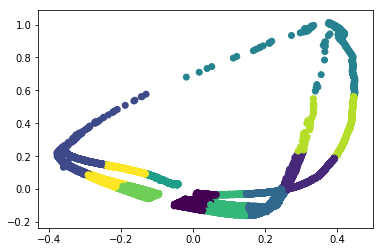

Comparing k-means clusters against the data:
col_0     0     1
row_0            
0         0  7551
1         0  2309
2      1581     0
3         0  3593
4        38   231
5      4037     0
6         0  3306
7      5765     0
8         0   627
9      2946     0


In [61]:
# Normalize the data.
#
x = df[["10k", "division", "25k", "age", "official", "genderdiv", "35k", "overall", "pace", "30k", "5k", "half", "20k", "40k"]]
X_norm = normalize(x)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=10).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

numpy.ndarray

In [49]:
from sklearn import metrics
metrics.adjusted_rand_score(y, y_pred)

0.06718146421757301

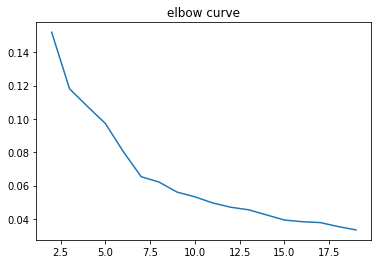

In [32]:
from scipy.spatial.distance import cdist

res = list()
n_cluster = range(2,20)
for n in n_cluster:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_norm)
    res.append(np.average(np.min(cdist(X_norm, kmeans.cluster_centers_, 'euclidean'), axis=1)))

plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()